TODO:
    
* Move print statements into a function
* Name variables well, maybe include a key at top so you don't have to keep making them over again


# 3 DAYS ARE MISSING!!!! 8, 9, 10

# Helpers

In [73]:
'''
Normalizes the standard deviation

Let coefficient of variation (CV):
CV >= 1 -> a relatively high variation
CV < 1  -> low variation
'''
def coeff_of_variation(mean, std):
    return std/mean

# Load the Datasets

We will be looking at ETH data from March 1, 2017 to present. Ethereum has been around before March 1st, but this month was when the price of Ether took off and then had far more variation.

Data is taken from https://www.investing.com/currencies/eth-usd, https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory/data, and https://etherscan.io/, and https://github.com/

## Load Ether data

In [74]:
%matplotlib inline

import pandas as pd
import datetime as dt

ether_df = pd.read_csv(filepath_or_buffer='./data/ETH_DataSet.csv', sep=',')
ether_df['Date'] = pd.to_datetime(ether_df['Date'])
ether_df['Date'] = [time.date() for time in ether_df['Date']]
ether_df.head(n=5).style

,Date,Price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused
0,2017-12-14,693.58,942559,14252053,9.62819e+07,66779.2,137630,1641.3,5694,26049,14.82,41791954659,7995365,43964305213
1,2017-12-13,699.09,909631,14031511,9.62611e+07,67295.2,134096,1612.74,5659,26216,14.96,38631503447,7995336,41625003479
2,2017-12-12,656.52,872340,13835239,9.62405e+07,63183.8,128932,1556.26,5715,25607,14.73,38367405491,7906762,42534383833
3,2017-12-11,513.29,828899,13685739,9.62199e+07,49388.7,128337,1575.71,5749,23554,14.68,35272081823,7799361,42190609044
4,2017-12-07,421.15,659068,13563836,9.61996e+07,40514.5,125210,1530.85,5798,17899,14.57,59656597683,6730260,37125990058


## Load Github Commit History Data

In [75]:
from pprint import pprint
import json
import os
from dateutil.parser import parse

directory_path = './data/github'

def format_date(date):
    return parse(date).strftime('%Y-%m-%d').lstrip("0").replace(" 0", " ")

def remove_time_from_commit(date):
    indexOfTimeStart = date.find('T')
    return date[0:indexOfTimeStart]

def get_commit_dict(directory_path):
    commit_dict = {};
    files = [f for f in os.scandir(directory_path) if os.path.isfile(f)]
    for f in files:
        with open(f) as data:    
            commit_history = json.load(data)
            nodes = commit_history['data']['repository']['ref']['target']['history']['edges']
            for node in nodes:
                date = format_date(remove_time_from_commit(node['node']['author']['date']))
                if date in commit_dict :
                    commit_dict[date] += 1
                else:
                    commit_dict[date] = 1
        return commit_dict
    
commit_dict = get_commit_dict(directory_path)

github_df = pd.DataFrame(list(commit_dict.items()), columns=['Date', 'Number_Commits'])
github_df['Date'] = pd.to_datetime(github_df['Date'])
github_df['Date'] = [time.date() for time in github_df['Date']]
github_df.head(n=5).style

,Date,Number_Commits
0,2017-11-02,2
1,2017-10-31,1
2,2017-10-29,2
3,2017-10-28,2
4,2017-10-27,2


## Combine the Ether Data and Commit History DataFrames

In [76]:
df = ether_df.merge(github_df, on='Date', how='left').fillna(0)
df.head(n=5).style

columns = df.columns
index = df.index

# Split DataFrame into data X and class labels y

In [77]:
X = df.drop('Price', axis=1)
y = df['Price']

# Data Exploration

TODO:
Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)

In [78]:
X.head(n=5).style

,Date,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,Number_Commits
0,2017-12-14,942559,14252053,9.62819e+07,66779.2,137630,1641.3,5694,26049,14.82,41791954659,7995365,43964305213,0
1,2017-12-13,909631,14031511,9.62611e+07,67295.2,134096,1612.74,5659,26216,14.96,38631503447,7995336,41625003479,0
2,2017-12-12,872340,13835239,9.62405e+07,63183.8,128932,1556.26,5715,25607,14.73,38367405491,7906762,42534383833,0
3,2017-12-11,828899,13685739,9.62199e+07,49388.7,128337,1575.71,5749,23554,14.68,35272081823,7799361,42190609044,0
4,2017-12-07,659068,13563836,9.61996e+07,40514.5,125210,1530.85,5798,17899,14.57,59656597683,6730260,37125990058,0


These are the 5 most recent Ethereum data points. There's a large disparity in value for these features, so normalizing the data points by taking the natural log of them is necessary, so that one feature does not outweigh the others just because of its magnitude.

In [79]:
y.head(n=5)

0    693.58
1    699.09
2    656.52
3    513.29
4    421.15
Name: Price, dtype: float64

These are the 5 most recent prices of Ether.

In [80]:
X.shape

(286, 14)

There are **249** data points and **14** features. The large number of features and small number of data points does present a problem for the predictions. I want to reduce my feature size, so my model does not suffer from the curse of dimensionality, i.e. as the number of features grows, the number of data points the model needs to properly train grows exponentially.

### Statistics on ether transactions 

I will focus on these 3 features: 

* ether transactions (eth_tx)
* ether gas price (eth_gasprice)
* number of aggregated github commits on the top 3 ethereum repositories (Number_Commits)

In [81]:
print("Ether Transactions:")
print(X['eth_tx'].describe())

print("CV:")
print(coeff_of_variation(X['eth_tx'].mean(), X['eth_tx'].std()))

Ether Transactions:
count       286.000000
mean     285778.730769
std      175827.938282
min       55386.000000
25%      113419.000000
50%      267624.500000
75%      392409.250000
max      942559.000000
Name: eth_tx, dtype: float64
CV:
0.6152590075844532


The mean of ether transactions is ~285,000. The standard deviation of ether transactions is ~175,000. The coefficient of variation (CV) is < 1, so there's not much variation in ether transactions. 

I expect that as ether transaction count increases, so does ether price, since this would imply that more people believe in the Ethereum product. If there weren't many Ether transactions, I don't believe the price would be high, since there would not be much incentive to trade a currency that not many others are using.

In [82]:
print("Ether Gas Price:")
print(X['eth_gasprice'].describe())

print("CV:")
print(coeff_of_variation(X['eth_gasprice'].mean(), X['eth_gasprice'].std()))

Ether Gas Price:
count    2.860000e+02
mean     2.402298e+10
std      7.371584e+09
min      1.037198e+10
25%      2.217629e+10
50%      2.295469e+10
75%      2.552619e+10
max      6.268273e+10
Name: eth_gasprice, dtype: float64
CV:
0.30685550143261486


The mean of ether gas price is 24,573,670,000. The standard deviation is 6,532,320,000. The coefficient of variation is < 1, so again there is not much variation of the ether gas price.

I expect that a lower ether gas price would give others more incentive to make more ether transactions. More ether transactions, should drive up the price of Ether.

In [83]:
print("Aggregated Number of Github Commits per Day of the Top 3 Ethereum Repositories:")
print(X['Number_Commits'].describe())

print("CV:")
print(coeff_of_variation(X['Number_Commits'].mean(), X['Number_Commits'].std()))

Aggregated Number of Github Commits per Day of the Top 3 Ethereum Repositories:
count    286.000000
mean       4.748252
std        5.674775
min        0.000000
25%        0.000000
50%        3.000000
75%        8.000000
max       32.000000
Name: Number_Commits, dtype: float64
CV:
1.1951292668316416


The mean of number of total commits per day is 5.45. The standard deviation is 7.76. The coefficient of variation is >= 1, so again there a lot of variation in the number of commits per day.

I am not sure whether or not total commits would influence the price of Ether, but if it did, I would expect that more commits would imply a higher price of Ether. This is because the stronger the developer community is around Ethereum, the more people would trust Ethereum, so the higher the price of Ether,

In [84]:
print("Ether Price Statistics:")
print(y.describe())

print("CV:")
print(coeff_of_variation(y.mean(), y.std()))

Ether Price Statistics:
count    286.000000
mean     231.680594
std      132.418935
min       16.510000
25%       90.017500
50%      271.785000
75%      309.385000
max      699.090000
Name: Price, dtype: float64
CV:
0.5715581616889741


Ether Price statistics shows Ether price data. The min price of Ether and max price of Ether are \$16.51 and \$389.90 respectively. The mean is \$205.03 and the standard deviation is \$114.07. The CV is < 1, so this means that the price of Ether has not fluctuated too much.

## Exploratory Visualization

I will be looking at:

* Standardized Ether Price vs Time
* Standardized Ether Transaction Count vs Time
* Standardized Ether Price and Transaction Count vs Time
* Standardized Ether Gas Price and Transaction Count vs Time
* Standardized Aggregated Number of Commits from Top 3 Ethereum Repositories vs Time

## Standardized Ether Price vs Time

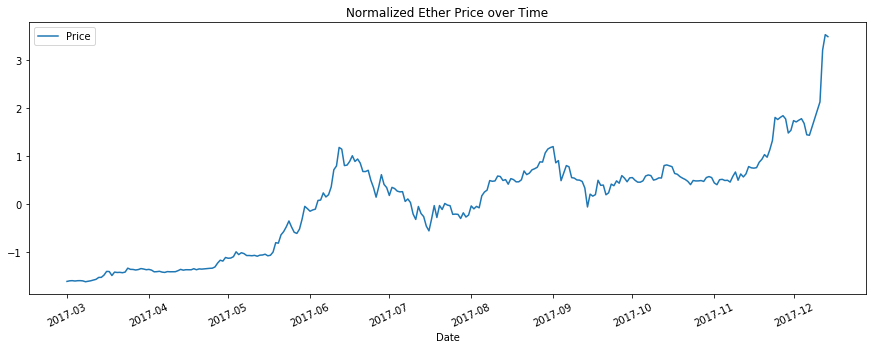

In [85]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df_no_date = df.drop('Date', axis=1)

# Standardize features by removing the mean and scaling to unit variance
scaled_no_date = StandardScaler().fit_transform(df_no_date)
scaled_df_no_date = pd.DataFrame(scaled_no_date, index=df_no_date.index, columns=df_no_date.columns)
scaled_df = pd.concat([scaled_df_no_date, X['Date'].to_frame()], axis=1)

scaled_df.plot(title='Normalized Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5))
plt.show()
plt.close()

The price stagnates for the first 3 months, then spikes exponentially. For the remaining months, the normalized price oscillates between 0 and 1.5. The price does not hold at a high value for very long, as it dips immediately after.

## Standardized Ether Transaction Count over Time

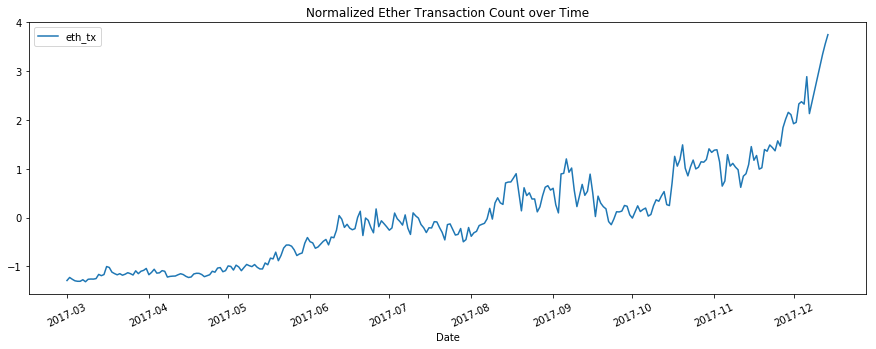

In [86]:
scaled_df.plot(title='Normalized Ether Transaction Count over Time', x='Date', y='eth_tx', rot=25, figsize=(15,5))
plt.show()
plt.close()

The ether transaction count, like price, stagnates for the first 3 months and then increases for the remaining months. It is evident that in general, as price increases, so does transaction count and as price decreases, so does transaction count.

## Standardized Ether Price and Transaction Count vs Time

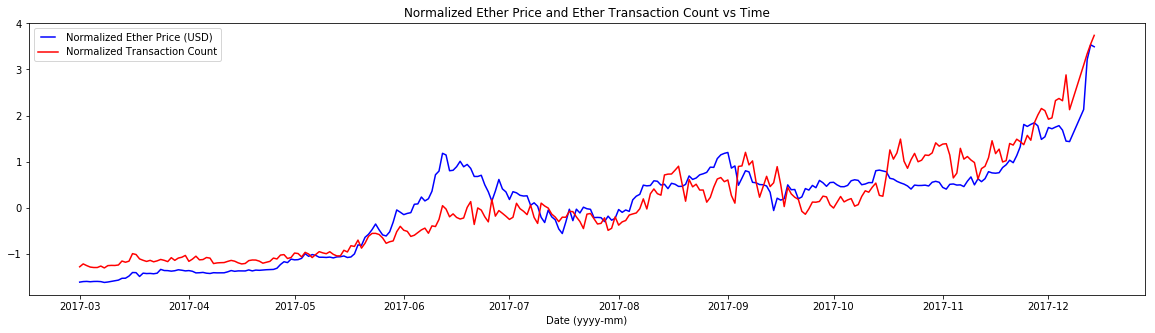

In [87]:
from matplotlib.legend_handler import HandlerLine2D

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Normalized Ether Price and Ether Transaction Count vs Time')
line1, = ax.plot(scaled_df['Date'], scaled_df['Price'], 'b', label='Normalized Ether Price (USD)')
line2, = ax.plot(scaled_df['Date'], scaled_df['eth_tx'], 'r', label='Normalized Transaction Count')
ax.set_xlabel('Date (yyyy-mm)')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

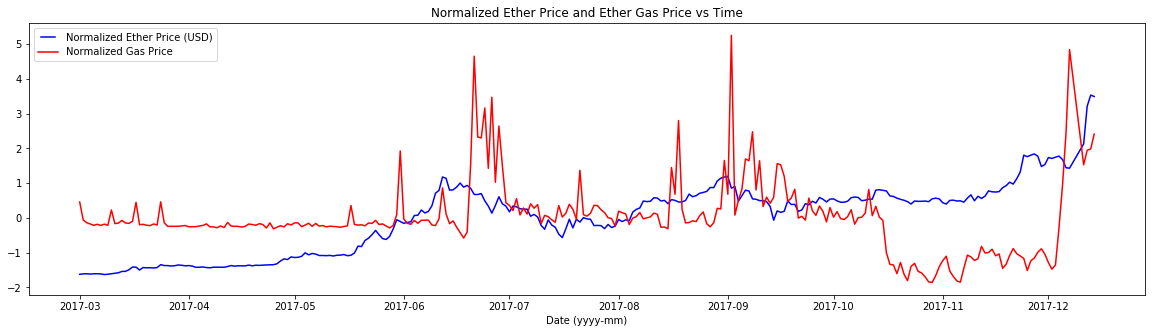

In [88]:
from matplotlib.legend_handler import HandlerLine2D

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Normalized Ether Price and Ether Gas Price vs Time')
line1, = ax.plot(scaled_df['Date'], scaled_df['Price'], 'b', label='Normalized Ether Price (USD)')
line2, = ax.plot(scaled_df['Date'], scaled_df['eth_gasprice'], 'r', label='Normalized Gas Price')
ax.set_xlabel('Date (yyyy-mm)')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

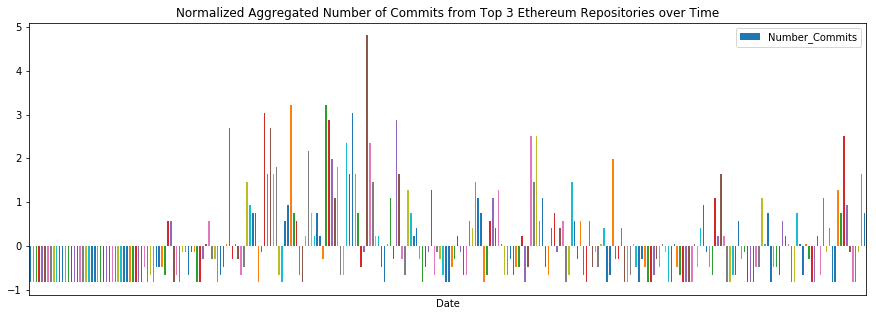

In [89]:
import matplotlib.ticker as plticker

scaled_df.plot(title='Normalized Aggregated Number of Commits from Top 3 Ethereum Repositories over Time', x='Date', y='Number_Commits', kind='bar', rot=45, figsize=(15,5))
plt.tick_params(bottom='off', labelbottom='off')
plt.show()
plt.close()

TODO: actually label with xticks, provide an explanation

## Normalize Data before PCA

I removed the Date column, since I only wanted to consider numerical values when performing PCA

Then, I normalized the data using z-scaling to prevent certain features from dominating other features.

The explained variance ratio and the cumulative explained variance ratio in the below graph, shows that the variances slope is almost linear in logarithmic scale. Because of this, it seems that keeping 3 principal components we can explain ∼90% of the full variance. (0.658 + 0.176 + 0.077 = 0.911)

https://stats.stackexchange.com/questions/158281/can-pca-be-applied-for-time-series-data
One approach could be to take the first time differences of your 12 variables to ensure stationarity. Then calculate the 12×12 covariance matrix and perform PCA on it. This will be some sort of average PCA over the whole time span, and will not say anything about how the different timelags affect each other. But it could be a good starting point. 
	
I mean the first difference, so for each of the twelve x's I would do x_t - x_t-1

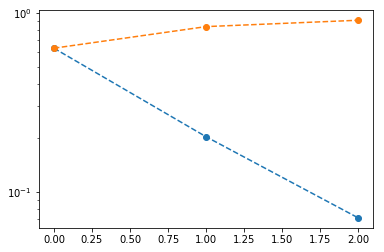

Explained variance ratio:
[ 0.63369604  0.20282989  0.07138616]


In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_no_date = X.drop('Date', axis=1)
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(X_no_date)
z_data = PCA(n_components=3).fit(z_data) 

plt.semilogy(z_data.explained_variance_ratio_, '--o')
plt.semilogy(z_data.explained_variance_ratio_.cumsum(), '--o');
plt.show()
plt.close()

# explained_variance_ratio_ - Percentage of variance explained by each of the selected components.
print("Explained variance ratio:")
print(z_data.explained_variance_ratio_)

univariate ARIMA with time and price only following 
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ and 
https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/ with time series split

multivariate LSTM following https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ - no pca

Bayesian Linear Regression

# Univariate ARIMA

## Test For Stationarity on the Time Series Data

First, I will plot time and price to see if timeseries is **stationary**. To perform univariate ARIMA, the timeseries data must be stationary. I will use the **Augmented Dickey-Fuller (ADF) Test** to test stationarity of the timeseries data. Comparing the ADF test statistic and Critical Values, specifically the value at 1%, will determine whether or not the data is stationary. The more negative the ADF test statistic, the more likely it is that one would reject the null hypothesis (i.e. the timeseries data is stationary). The criterion for how negative the ADF test statistic has to be is that it should be more negative than the ADF critical value at 1%, which would mean that there would be a high probability that the result can be taken as truth. Therefore, I want a large negative ADF test statistic, one that is less than the critical value at 1%, so that I can ensure my time series is stationary.

**I will run ADF Tests on:**
1. Original Time Series Data
2. Differencing - I will try to model the differences of the terms and not the actual term. For instance, **x(t) – x(t – 1)**.

## ADF Test on Original Time Series Data

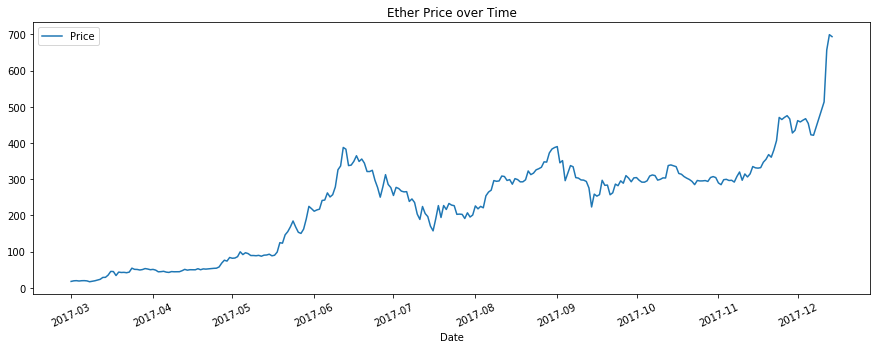

ADF ts
ADF Statistic: -3.280782
p-value: 0.015760
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Plot original price vs time
ts = df[['Date', 'Price']]
ts.plot(title='Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5))
augmented_dickey_fuller = adfuller(ts['Price'])
plt.show()
plt.close()

# Print ADF Results
print('ADF ts')
print('ADF Statistic: %f' % augmented_dickey_fuller[0])
print('p-value: %f' % augmented_dickey_fuller[1])
print('Critical Values:')
for key, value in augmented_dickey_fuller[4].items():
    print('\t%s: %.3f' % (key, value))
plt.xlabel='Date (YYYY-MM)'
plt.ylabel='Ether Price (USD)'

Running an ADF test on the original time series data returns:

* **ADF Statistic:** -3.281
* **p-value:** 0.016
* **Critical Values:**
    1%: -3.454
	5%: -2.872
	10%: -2.572
    
The ADF test statistic is -3.281 and is not less than the value of -3.454 at 1%. This means that we may have a unit root (and will have to accept the null hypothesis). Our data is non-stationary, given this ADF test. In addition, the graph is also in agreement with the data being non-stationary. One can see that the mean of the data is varying over time. On average, the price of Ether is growing over time.

## ADF on First Differences of the Ether Price Data

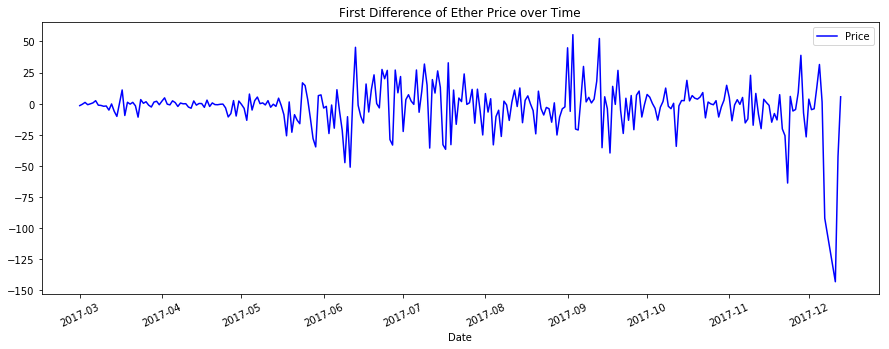

ADF First Difference
ADF Statistic: -13.992649
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [104]:
# Plot the Firsts Differences of Ether Price vs time
ts_first_differences = ts.copy(deep=True)
ts_first_differences['Price'] = ts['Price'].diff()
ts_first_differences.dropna(inplace=True)
ax = ts_first_differences.plot(title='First Difference of Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5), color='blue')
plt.show()
plt.close()

augmented_dickey_fuller = adfuller(ts_first_differences['Price'])
print('ADF First Difference')
print('ADF Statistic: %f' % augmented_dickey_fuller[0])
print('p-value: %f' % augmented_dickey_fuller[1])
print('Critical Values:')
for key, value in augmented_dickey_fuller[4].items():
	print('\t%s: %.3f' % (key, value))

### Running an ADF Test on the First Differences of Ether Price

To make the timeseries data stationary, I will take the first difference of the Ether Price data.

Running an ADF test on the transformed time series data returns:

* **ADF Statistic:** -13.993
* **p-value:** 0.000000
* **Critical Values:**
	1%: -3.454
	5%: -2.872
	10%: -2.572

The ADF test statistic is -13.993 and is a lot less than the value of -3.457 at 1%. This means that the time series data is stationary.

# Find the right parameters to be used in the ARIMA model

To find the parameters of the ARIMA model, I need to answer two questions:
1. **Is this an AR or MA process?**
2. **What is the order of the AR or MA process?**

I will use a **Total Correlation Chart** (also known as Auto – correlation Function / ACF) to determine whether is is an AR or MA process. ACF is a plot of total correlation between different lag functions. For example, I will compare my autocorrelation plot with the two plots below. Note: an AR process will have a **gradual correlation decrease**, a MA process will have an **abrupt decrease**.:

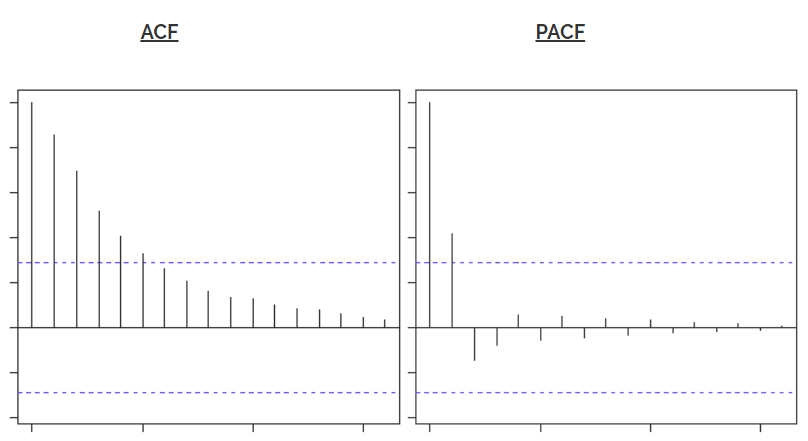

Figure from https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

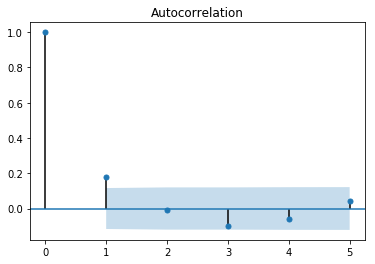

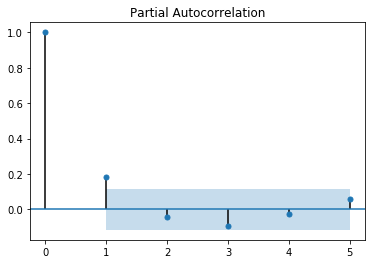

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(x=ts_first_differences['Price'], lags=5)
fig = plot_pacf(x=ts_first_differences['Price'], lags=5)

Both ACF and PACF plots show a sharp decrease in correlations and both have negative autocorrelations at lag 2. Therefore, this is both an AR and MA series.

# Ether Time Series Data to be fed into ARIMA Model

Below are the five most recent Ether price data. This data will be then split into training and testing sets.

In [110]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

# AR model of 2, difference order of 1 to make the time series stationary, MA model of 2
# timeseries index must contain dates
ts.set_index('Date').head(n=5).style

,Price
Date,
2017-12-14,693.58
2017-12-13,699.09
2017-12-12,656.52
2017-12-11,513.29
2017-12-07,421.15


# Plot of Ether Time Series Data to be fed into ARIMA Model

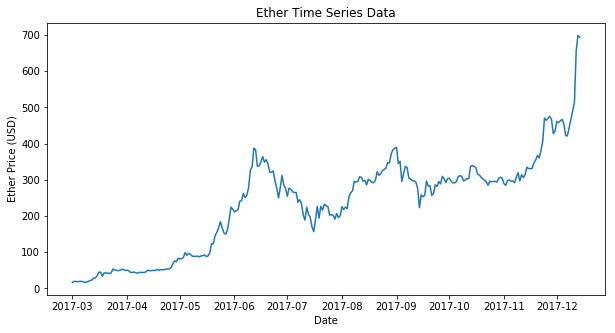

In [111]:
from matplotlib import pyplot

f, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts['Date'],ts['Price'])
ax.set_title('Ether Time Series Data')
ax.set_xlabel('Date')
ax.set_ylabel('Ether Price (USD)')
pyplot.show()

# Grid Search ARIMA Model Hyperparameters

I will evaluate a number of hyperparameters for the ARIMA model by using grid search, which will find the combination of hyperparameters that yields the lowest mean squared error. I need to find the optimal hyperparameters for ARIMA, namely (p, d, q).

* p: lag values
* d: difference iterations
* q: residual error lag values

(Taken directly from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ to verify my own hyperparameter selection from looking at the autocorrelation plot.)

In [69]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    print(mse)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA %s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts['Price'].values, p_values, d_values, q_values)

38846.4003936
ARIMA(0, 0, 0) MSE=38846.400
11079.4108919
ARIMA(0, 0, 1) MSE=11079.411
65.4684726131
ARIMA(0, 1, 0) MSE=65.468
64.5555824873
ARIMA(0, 1, 1) MSE=64.556
64.3844354448
ARIMA(0, 1, 2) MSE=64.384
111.992842713
ARIMA(0, 2, 0) MSE=111.993
71.1518876711
ARIMA(0, 2, 1) MSE=71.152
73.1632827346
ARIMA(0, 2, 2) MSE=73.163
77.1623145395
ARIMA(1, 0, 0) MSE=77.162
76.0639520243
ARIMA(1, 0, 1) MSE=76.064
76.0694969638
ARIMA(1, 0, 2) MSE=76.069
64.2636515625
ARIMA(1, 1, 0) MSE=64.264
64.488206941
ARIMA(1, 1, 1) MSE=64.488
92.3866832932
ARIMA(1, 2, 0) MSE=92.387
72.3993892254
ARIMA(1, 2, 1) MSE=72.399
73.0151801395
ARIMA(1, 2, 2) MSE=73.015
76.1167446269
ARIMA(2, 0, 1) MSE=76.117
75.6356653658
ARIMA(2, 0, 2) MSE=75.636
64.5554771481
ARIMA(2, 1, 0) MSE=64.555
64.9774115375
ARIMA(2, 1, 1) MSE=64.977
62.1650103975
ARIMA(2, 1, 2) MSE=62.165
97.7693205957
ARIMA(2, 2, 0) MSE=97.769
73.7845088703
ARIMA(2, 2, 1) MSE=73.785
72.5269227869
ARIMA(2, 2, 2) MSE=72.527
Best ARIMA (2, 1, 2) MSE=62.165


The best hyperparameters are (2,1,2) with a 62.165 mean squared error (MSE). These hyper parameters have the lowest MSE. By viewing the autocorrelation plot, I had predicted (2,1,2) as the hyperparameters, the same as found by grid search. Though I found the an optimal parameter set of (2,1,2), when I used that value to perform a solling forecast, it would not converge, so instead I will use the parameters with the next lowest MSE, (1,1,0).

# Perform a Rolling Forcast with Univariate ARIMA Models

`TimeSeriesSplit` will be used to create a `time series cross validator` called splits. This cross validator will be used to provide multiple training and testing splits of the ether price data. Then, perform a rolling forcast with a univariate ARIMA model, i.e. for each new observation, create a new ARIMA model. Finally, make a new prediction for each each model.

(Adapted from  https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

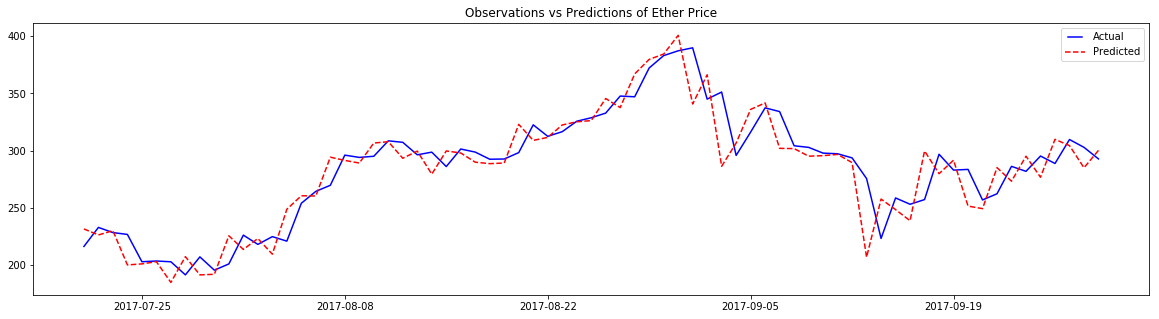

Test MSE: 386.269
Test RMSE: 19.654


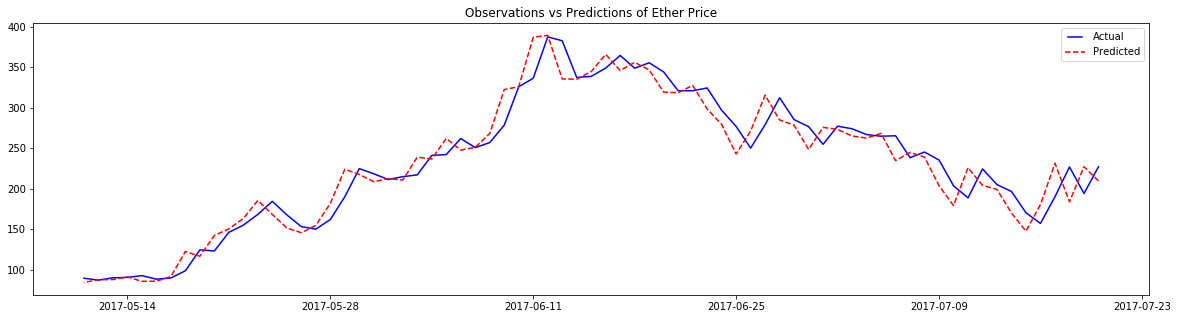

Test MSE: 429.015
Test RMSE: 20.713


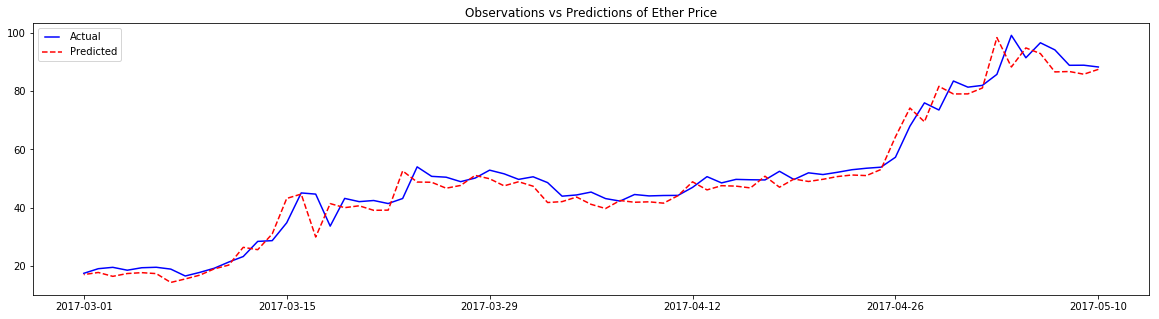

Test MSE: 19.836
Test RMSE: 4.454


In [116]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.legend_handler import HandlerLine2D
from math import sqrt

splits = TimeSeriesSplit(n_splits=3)

ORDER = (1,1,0)

for train_indices, test_indices in splits.split(ts):
    train = ts.iloc[train_indices]
    test = ts.iloc[test_indices]
            
    # Drop NaN
    train = train.dropna()
    test = test.dropna()
            
    # Historical Ether prices
    history = [x for x in train['Price']]
    
    # Rolling forecast with the ARIMA model - make a new model for each new observation
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=ORDER)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast() # To predict 7 steps out, set steps = 7 
        yhat = output[0][0]
        predictions.append(yhat)
        obs = test.iloc[t]['Price']
        history.append(obs)
        # print('predicted=%f, expected=%f' % (yhat, obs))
    
    fig, ax = pyplot.subplots(figsize=(20, 5))
    ax.set_title('Observations vs Predictions of Ether Price')
    line1, = ax.plot(test['Date'],test['Price'], 'b', label='Actual')
    line2, = ax.plot(test['Date'], predictions, 'r--', label='Predicted')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
    pyplot.show()
        
    mse = mean_squared_error(test['Price'].values, predictions)  
    rmse = sqrt(mean_squared_error(test['Price'].values, predictions))
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)

In [140]:
import numpy as np

# Train on all but the last 7 data points. Test on the next 7 data points.
print('Total data points: ', len(ts))

# Split into Training and Testing Data
ts_reversed = ts.copy(deep=True).iloc[::-1].set_index('Date') # reverse the dataframe to predict in the future
train_index = len(ts) - 1 - 7 # subtract last 7 days to predict

train = ts_reversed[0:train_index]
test = ts_reversed[train_index:len(ts) - 1]

# Fit ARIMA Model
model = ARIMA(train['Price'], order=ORDER)
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=7) # To predict 7 steps out, set steps = 7 

last_train_price = train.iloc[len(train) - 1]['Price']
print('Last training price before prediction:\n', last_train_price)
print("7 Day Forcast:")
print(forecast[0])
print('Actual 7 Day Prices:\n', test['Price'].values)

Total data points:  286
Last training price before prediction:
 462.81
7 Day Forcast:
[ 464.36581107  465.97436211  467.58206878  469.18978897  470.79750895
  472.40522893  474.0129489 ]
Actual 7 Day Prices:
 [ 466.93  453.96  422.48  421.15  513.29  656.52  699.09]


The univariate ARIMA model does not do very well to predict values a week into the future. The model does do pretty well predicting the first two values.

Difference in prediction from actual for the 7 forcasted values:
[2, 12, 45, 48, 43, 184, 225]

Since Ether price is so volatile, it is best to only make predictions for a day or so in advance. After that, there's too much variation to make an accurate prediction with univariate ARIMA. Maybe a multivariate model will capture the variation in price better.

### Residual Plot

The residuals are difference between the actual and predicted values. The residual plot should look random around 0 and do not show any trend, so this means that there aren't any missing trends or elements in the ARIMA model.

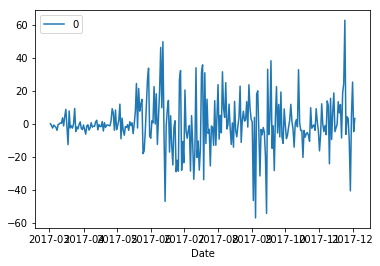

In [141]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

This is the density plot of the residual error values. The errors look like they are in a Gaussian distribution, and are centered at 0. The mean is around 0, so this suggests that there is not much bias in the prediction. 

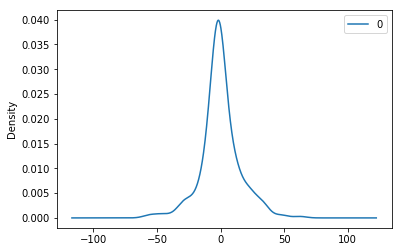

                0
count  277.000000
mean    -0.000035
std     15.358081
min    -57.014037
25%     -5.615188
50%     -1.138004
75%      5.174552
max     62.638478


In [142]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

This is an autocorrelation plot. Autocorrelation determines the amount of the relationship between a current observation and previous observations. There is not an obvious autocorrelation trend in the plot. It seems that earlier lags have larger autocorrelation. This makes sense, because the first few months of Ether price data showed generally low Ether price data with low variation in price. Thus, there is a bit of a relationship between early Ether price timeseries data points. However, in later months, Ether price data was a lot more random, so the autocorrelations for later timeseries data is closer to 0 than the autocorrelations in earlier months which were much larger in magnitude.

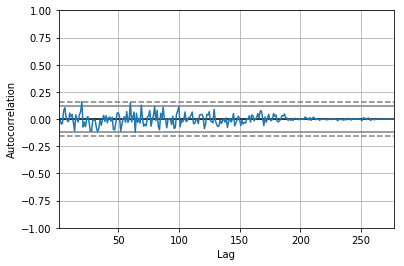

In [146]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(residuals)

# Long-Short Term Memory (LSTM) Recurrent Neural Network

# Ether Time Series Data to be fed into LSTM RNN

Drop the last 7 days of data. The price on these days will be predicted.

In [169]:
lstm_ts = df.copy(deep=True)
lstm_ts = lstm_ts.drop(lstm_ts.head(7).index).set_index('Date')
lstm_ts.head().style

,Price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,Number_Commits
Date,,,,,,,,,,,,,,
2017-12-04,466.93,701834,13091051,9.61374e+07,44889.4,125870,1546.95,5671,19741,14.86,21962218932,6722294,34887121288,0
2017-12-03,462.81,693808,12965590,9.6117e+07,44483.9,121829,1542.75,6029,19326,14.08,14068434201,6721650,33003047721,0
2017-12-02,457.96,627785,12861547,9.60966e+07,44008.4,125605,1520.78,6053,17954,14.07,13179215357,6720306,30183667434,0
2017-12-01,461.58,622720,12765900,9.60764e+07,44347,125493,1508.04,6127,18184,13.89,14561757161,6718817,31811531693,0
2017-11-30,434.85,655457,12661777,9.6056e+07,41769.9,124830,1537.2,6151,18059,13.83,16354038320,6716861,28880894729,0


## Plot of Each Column of Ether Data

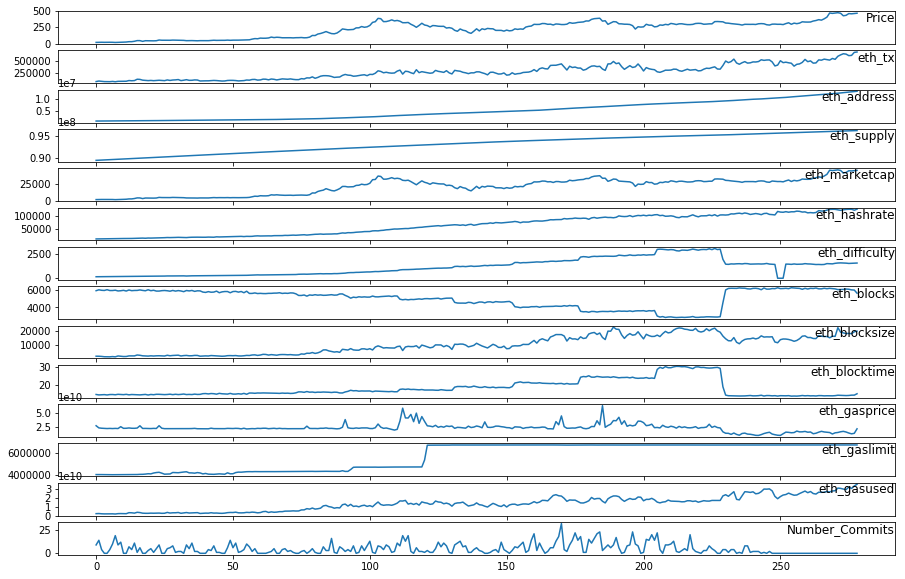

In [186]:
from matplotlib import pyplot as plt

columns = ['Price', 'eth_tx', 'eth_address', 'eth_supply', 'eth_marketcap', 
           'eth_hashrate', 'eth_difficulty', 'eth_blocks', 'eth_blocksize',
           'eth_blocktime', 'eth_gasprice', 'eth_gaslimit', 'eth_gasused',
           'Number_Commits']

values = lstm_ts.copy(deep=True).iloc[::-1].values

i = 1
plt.figure(figsize=(15, 10))
for column in columns:
    plt.subplot(len(columns), 1, i)
    plt.plot(values[:, i-1])
    plt.title(columns[i-1], y=0.5, loc='right')
    i += 1
plt.show()

# Optimizing 

* Do I need more data points for the prediction to get better? - graph it
* Should I try using another model?